## Sementic Segmentation
- classifier와 비슷한 구조
- encoder로 위치, 공간에 대한 특성유지시킨채로 feature extraction (No FC Layer)
- Decoder를 통해 복원(high resolution restoration)

- 실습내용
    - 데이터 텐서연산
    - U-net 아키텍처
    - Cross-entropy, Dice Loss Funtion, SGDM
    - Dice similarity coefficient 성능지표

In [18]:
import os
import pandas as pd
import numpy as np

data_dir = '/Users/ppangppang/Desktop/팡팡팡/DS/CV'
data_df = pd.read_csv(os.path.join(data_dir, "train.csv"))
data_df.head()

,ImageId,MaskId
0,ID00007637202177411956430_0.jpg,ID00007637202177411956430_mask_0.jpg
1,ID00007637202177411956430_1.jpg,ID00007637202177411956430_mask_1.jpg
2,ID00007637202177411956430_2.jpg,ID00007637202177411956430_mask_2.jpg
3,ID00007637202177411956430_3.jpg,ID00007637202177411956430_mask_3.jpg
4,ID00007637202177411956430_4.jpg,ID00007637202177411956430_mask_4.jpg


In [19]:
def extract_client_id(x):
    return x.split("_")[0]

In [20]:
data_df["Id"] = data_df.ImageId.apply(lambda x:extract_client_id(x))
data_df

,ImageId,MaskId,Id
0,ID00007637202177411956430_0.jpg,ID00007637202177411956430_mask_0.jpg,ID00007637202177411956430
1,ID00007637202177411956430_1.jpg,ID00007637202177411956430_mask_1.jpg,ID00007637202177411956430
2,ID00007637202177411956430_2.jpg,ID00007637202177411956430_mask_2.jpg,ID00007637202177411956430
3,ID00007637202177411956430_3.jpg,ID00007637202177411956430_mask_3.jpg,ID00007637202177411956430
4,ID00007637202177411956430_4.jpg,ID00007637202177411956430_mask_4.jpg,ID00007637202177411956430
...,...,...,...
16703,ID00426637202313170790466_403.jpg,ID00426637202313170790466_mask_403.jpg,ID00426637202313170790466
16704,ID00426637202313170790466_404.jpg,ID00426637202313170790466_mask_404.jpg,ID00426637202313170790466
16705,ID00426637202313170790466_405.jpg,ID00426637202313170790466_mask_405.jpg,ID00426637202313170790466
16706,ID00426637202313170790466_406.jpg,ID00426637202313170790466_mask_406.jpg,ID00426637202313170790466


In [21]:
## client 인원 확인
client_ids = np.unique(data_df.Id.values)
print(len(client_ids))

112


In [29]:
## 환자 1명
index = 0
client_data = data_df[data_df.Id == client_ids[index]][["ImageId", "MaskId"]]

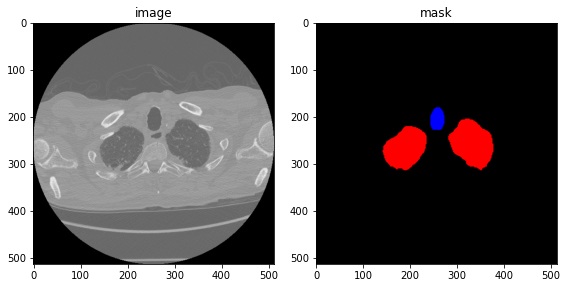

In [30]:
import cv2
import matplotlib.pyplot as plt

sub_index = 3
img_name, mask_name = client_data.iloc[sub_index].values
img_path, mask_path = os.path.join(data_dir, "images", img_name), os.path.join(data_dir, "masks", mask_name)
image = cv2.imread(img_path)
mask = cv2.imread(mask_path)
thres = 240
mask[mask < thres] = 0
mask[mask >= thres] = 255

plt.figure(figsize=(8,6))
plt.subplot(121)
plt.title("image")
plt.imshow(image)
plt.subplot(122)
plt.title("mask")
plt.imshow(mask)
plt.tight_layout()

In [31]:
def get_client_data(data_df, index):
    client_ids = np.unique(data_df.Id.values)
    client_id = client_ids[index]
    client_data = data_df[data_df.Id == client_id]
    image_files = list(client_data["ImageId"])
    mask_files = list(client_data["MaskId"])
    return client_id, image_files, mask_files

In [32]:
regions = ["background", "trachea", "heart", "lung"]
colors = ((0,0,0), (255, 0, 0), (0, 255, 0), (0, 0, 255))

In [38]:
## image 영상으로재생

index = 0
client_id, image_files, mask_files = get_client_data(data_df, index)

canvas = np.zeros(shape=(512, 2*512+50, 3), dtype=np.uint8)
for i in range(len(image_files)):
    image = cv2.imread(os.path.join(data_dir, "images", image_files[i]))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(os.path.join(data_dir, "masks", mask_files[i]))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    thres = 240
    mask[mask < thres] = 0
    mask[mask >= thres] = 255
    grid_pad = 50
    
    canvas[:, :512, :] = image
    canvas[:, 512+grid_pad:2*512+grid_pad, :] = mask
    
    text_buff = 410
    for j in range(1, len(regions)):
        cv2.putText(canvas, f'{regions[j].upper()}', (900, text_buff), cv2.FONT_HERSHEY_SIMPLEX, 1, colors[j], 2)
        text_buff += 40
    
    cv2.imshow('CT frames', canvas)
    key = cv2.waitKey(60)
    if key == 27:
        break
cv2.destroyAllWindows()

### 데이터셋 준비

- train.csv에 있는 데이터 trian으로 옮기기
- train
    - images
    - masks
- test
    - images
    - masks    

In [39]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

IMAGE_SIZE = 224

class CT_dataset():
    def __init__(self, data_dir, phase, transformer=None):
        self.phase = phase
        self.images_dir = os.path.join(data_dir, phase, "images")
        self.masks_dir = os.path.join(data_dir, phase, "masks")
        self.image_files = [filename for filename in os.listdir(self.images_dir) if filename.endswith("jpg")]
        self.mask_files = [filename for filename in os.listdir(self.masks_dir) if filename.endswith("jpg")]
        assert len(self.image_files) == len(self.mask_files)
        
        self.transformer = transformer
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, index):
        image = cv2.imread(os.path.join(self.images_dir, self.image_files[index]))
        image = cv2.resize(image, dsize=(IMAGE_SIZE,IMAGE_SIZE), interpolation=cv2.INTER_LINEAR)
        mask = cv2.imread(os.path.join(self.masks_dir, self.mask_files[index]))
        mask = cv2.resize(mask, dsize=(IMAGE_SIZE,IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
        mask[mask < 240] = 0
        mask[mask >= 240] = 255
        mask = mask / 255
        
        mask_H, mask_W, mask_C = mask.shape
        background = np.ones(shape=(mask_H, mask_W))
        background[mask[...,0] != 0] = 0
        background[mask[...,1] != 0] = 0
        background[mask[...,2] != 0] = 0
        mask = np.concatenate([np.expand_dims(background, -1), mask], axis=-1)
        mask = np.argmax(mask, axis=-1, keepdims=False)
        
        if self.transformer:
            image = self.transformer(image)
        target = torch.from_numpy(mask).long()
        return image, target

In [40]:
def build_transformer():
    transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return transformer

In [41]:
def collate_fn(batch):
    images = []
    targets = []
    for a, b in batch: 
        images.append(a)
        targets.append(b)
    images = torch.stack(images, dim=0) 
    targets = torch.stack(targets, dim=0)

    return images, targets

In [42]:
data_dir = '/Users/ppangppang/Desktop/팡팡팡/DS/CV'
transformer = build_transformer()
tr_dataset = CT_dataset(data_dir=data_dir, phase="train", transformer=transformer)
val_dataset = CT_dataset(data_dir=data_dir, phase="val", transformer=transformer)
tr_dataloader = DataLoader(tr_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/ppangppang/Desktop/팡팡팡/DS/CV/train/images'